# In each grey box, when asked, press Ctrl+Enter to "execute"

In [1]:
!pip install redispy

# This is gets our algorithms for today

In [22]:
from prescriptions import *

# We have to get the data too...

In [17]:
fetch_prescription_data('../prescriptions.csv')

If you joined us for the big data masterclass, you will have seen how loading the whole multi-year dataset is too big for one notebook/computer, but we can do calculations on each month and recombine them at the end. For ML, we load one month at a time to see how more data changes the outcome.

### So each of us will calculate one month

In [23]:
month, year = get_my_month_year()
month, year

(1, 2015)

In [4]:
data_for_one_month = load_prescription_data_filter_by_month('../prescriptions.csv', month, year)

21900000it [01:34, 231690.66it/s]                              


### Lets see what the data contains...

In [5]:
data_for_one_month

PRACTICE  Year Month          VTM_NM  \
8200000       60  2015     1    Fexofenadine   
8200001       60  2015     1     Finasteride   
8200002       60  2015     1  Flucloxacillin   
8200003       60  2015     1     Fluconazole   
8200004       60  2015     1     Fluconazole   
...          ...   ...   ...             ...   
8599995      624  2015     1        Carbomer   
8599996      624  2015     1        Carbomer   
8599997      624  2015     1        Carbomer   
8599998      624  2015     1      Carmellose   
8599999      624  2015     1      Carmellose   

                                                    VMP_NM  \
8200000                          Fexofenadine 30mg tablets   
8200001                            Finasteride 5mg tablets   
8200002                      Flucloxacillin 500mg capsules   
8200003                         Fluconazole 150mg capsules   
8200004                         Fluconazole 150mg capsules   
...                                                    ...   
8599995                      Carbomer '980' 0.2% eye drops   
8599996                      Carbomer '980' 0.2% eye drops   
8599997  Carbomer '980' 0.2% eye drops 0.6ml unit dose ...   
8599998                          Carmellose 0.5% eye drops   
8599999                          Carmellose 0.5% eye drops   

                                           AMP_NM Presentation Strength  \
8200000                                         -       Tablet     30mg   
8200001                                         -       Tablet      5mg   
8200002                                         -      Capsule    500mg   
8200003                                         -      Capsule    150mg   
8200004                   Diflucan 150mg capsules      Capsule    150mg   
...                                           ...          ...      ...   
8599995               Viscotears 2mg/g liquid gel    Eye drops    0.20%   
8599996                       Xailin 0.2% eye gel    Eye drops    0.20%   
8599997  Viscotears 2mg/g eye gel 0.6ml unit dose    Eye drops    0.20%   
8599998                 Carmellose 0.5% eye drops     EYE DROP    0.50%   
8599999                Optive Plus 0.5% eye drops     EYE DROP    0.50%   

        Total Items Total Quantity  Gross Cost (£)  Actual Cost (£)  \
8200000           1             60            5.46             4.93   
8200001           5            140            6.80             6.16   
8200002           8            264           22.72            20.57   
8200003           4              4            3.56             3.23   
8200004           1              1            7.12             6.43   
...             ...            ...             ...              ...   
8599995          19            210           33.39            30.06   
8599996           1             10            3.25             2.93   
8599997           2             60           10.84             9.68   
8599998           2             11            8.24             7.43   
8599999           3             40           29.96            26.95   

                BNF Code BNF Chapter BNF Section BNF Paragraph  \
8200000  0304010E0AAACAC           3           4             1   
8200001  0604020C0AAAAAA           6           4             2   
8200002  0501012G0AAABAB           5           1             1   
8200003  0502010B0AAABAB           5           2             1   
8200004  0502010B0BBABAB           5           2             1   
...                  ...         ...         ...           ...   
8599995  1108010B0BBAAAB          11           8             1   
8599996                -          11           8             1   
8599997  1108010B0BBABAC          11           8             1   
8599998                -          11           8             1   
8599999                -          11           8             1   

        BNF Sub-Paragraph  
8200000                 0  
8200001                 0  
8200002                 2  
8200003                 0  

# Can we teach a computer to predict the type ("Presentation") of a drug from its name and cost?

Lets build an ML model from our data...

## Focus on usable data

Data that contains lots of outliers or does not "feel" predictable, often is not -- we remove any prescriptions without real names (e.g. "-") or that cost over £100.

In [6]:
dataset = pd.DataFrame(data_for_one_month)
dataset = dataset[dataset['VTM_NM'].str.len() > 3]
dataset = dataset[dataset['Actual Cost (£)'] < 100]
dataset = pd.DataFrame(dataset)

Next, we need to make our groupings clear - human-written data often needs cleaned first!

In [25]:
tablets = ['Tablet',
 'Modified-release tablet',
 'MUCO-ADHESIVE BUCCAL TABLET',
 'TABLETS',
 'ORODISPERSIBLE TABLET',
 'Chewable tablet',
 'Gastro-resistant tablet',
 'Effervescent tablet',
 'Soluble tablet',
 'Buccal tablet',
 'TABLETS/GRANS',
 'Dispersible tablet',
 'ORODISP TABLET',
 'TABLET',
 'Tablets',
 'Sublingual tablet',
 'FASTAB',
 'Tablet for cutaneous solution'
]
capsules = [
 'Capsule', 'Modified-release capsule', 'Gastro-resistant capsule', 'CAPSULE'
]
drops = ['Eye drops',
 'DROPS',
 'EAR DROP',
 'Nasal drops',
 'Oral drops',
 'Ear drops',
 'Ear/eye drops solution',
 'EYE DROP',
 'EYE DROPS',
 'Ear/eye/nose drops solution',
 'Modified-release drops'
]
known_types = tablets + capsules + drops

We create a data column "Known Pres" to give a number to each of Tablet, Capsule and Drop respectively.

In [26]:
dataset = add_known_pres(dataset, tablets, capsules, drops)
dataset[['Presentation', 'Known Pres']]

Presentation  Known Pres
8200000       Tablet           1
8200001       Tablet           1
8200002      Capsule           2
8200003      Capsule           2
8200004      Capsule           2
...              ...         ...
8599995    Eye drops           3
8599996    Eye drops           3
8599997    Eye drops           3
8599998     EYE DROP           3
8599999     EYE DROP           3

[187167 rows x 2 columns]

# Can we predict the presentation from...

The name and the cost? To make it simpler, lets choose three "features": length of name, the suffix (last 3 letters) and the cost in £.

In [27]:
dataset['suffix'] = extract_suffices(dataset['VTM_NM'])

**Exercise**: How many prescriptions have a given suffix? Does this relate to type?

In [32]:
count_presentation_by_suffix(dataset, 'lin')

-lin
CAPSULE  1542
TABLET    296

For training ML, we have to make our data numerical, and scale (normalize) it to avoid one "feature" dominating the others.

In [33]:
features, denorm_len, denorm_cost = dataframe_to_features(dataset)
features

Suffix  Length of Name      Cost  Presentation
8200000  0.240385        0.230769  0.049305             1
8200001  0.144231        0.211538  0.061606             1
8200002  0.307692        0.269231  0.205721             2
8200003  0.278846        0.211538  0.032303             2
8200004  0.278846        0.211538  0.064306             2
...           ...             ...       ...           ...
8599995  0.317308        0.153846  0.300630             3
8599996  0.317308        0.153846  0.029303             3
8599997  0.317308        0.153846  0.096810             3
8599998  0.346154        0.192308  0.074307             3
8599999  0.346154        0.192308  0.269527             3

[187167 rows x 4 columns]

Final data preparation for applying the ML...

In [34]:
features, labels = features[['Suffix', 'Length of Name', 'Cost']].values, features['Presentation'].values
features, labels

(array([[0.24038462, 0.23076923, 0.04930493],
        [0.14423077, 0.21153846, 0.06160616],
        [0.30769231, 0.26923077, 0.20572057],
        ...,
        [0.31730769, 0.15384615, 0.09680968],
        [0.34615385, 0.19230769, 0.07430743],
        [0.34615385, 0.19230769, 0.26952695]]),
 array([1, 1, 2, ..., 3, 3, 3]))

In [35]:
classifier, predict = train_ml(features, labels, dataset, denorm_len, denorm_cost)

Score: 58.00% accurate with 22s training


Congratulations - you have trained an ML model!

# What answers can you find?

In [39]:
predict("Ampicillin", "£15.00")

Predicting for -lin with 10 characters, costing £15.00


'TABLET'

In [15]:
get_frequencies_for_predictions(classifier, features[::100])

Frequency
CAPSULE        389
DROP           430
TABLET        1053

We can understand this a little better visually:

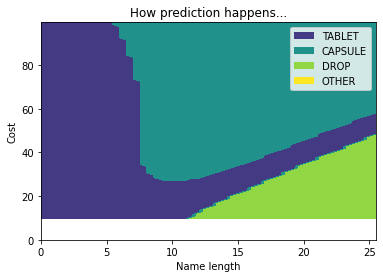

In [40]:
SUFFIX = 'lin'
decision_by_suffix(SUFFIX, classifier, features, denorm_len, denorm_cost)

**Exercise**: try experimenting by changing the numbers in the line below to target areas in the plot above

In [43]:
predict('Optrilol', '£20')

Predicting for -lol with 8 characters, costing £20.00


'CAPSULE'

**Exercise**: try this for some of the suffices you tried above - do you get the answers you expect?

In [44]:
# This uses the ML classifier to check 10% of the whole dataset
def predictor(row):
    return predict(row['VTM_NM'], row['Actual Cost (£)'], silent=True)

In [45]:
check_sample(dataset, predictor)

Correct 52.41% of the time


# But wait...

What happens if we just assume everything is a tablet?

In [46]:
# This uses the ML classifier to check 10% of the whole dataset
def predictor(row):
    return 'TABLET'

In [47]:
check_sample(dataset, predictor)

Correct 75.10% of the time


# Can you see a way that we could have shrunk our training data, and even improved accuracy?

Hint: two rows saying the same thing tell us nothing new